# Dispersion and its matching
We will show different technique to match the dispersion in a lattice. In an accelerator we need in some case insertions with zero dispersion (e.g., in the experimental IR to reduce the beam size, in the injection/extraction region, or for specific instruments or RF devices to decouple transverse and longitudinal properties).

In [21]:
from cpymad.madx import Madx
madx = Madx()
import matplotlib.pyplot as plt
#run_line_magic('matplotlib', 'inline')
#get_ipython().magic('matplotlib inline')
get_ipython().run_line_magic('matplotlib', 'inline')
%config InlineBackend.figure_format = 'retina' # retina display
import matplotlib.patches as patches

def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5,lw=3):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.11.08 14:58:50      +
  ++++++++++++++++++++++++++++++++++++++++++++


## Dispersion waves and dispression suppressors
We will consider now the impact of few dipoles on the dispersion, more technically the dispersive response of a dipole in a transfer line (we are not imposing the periodicity of the solution).

(-5.0, 150.0)

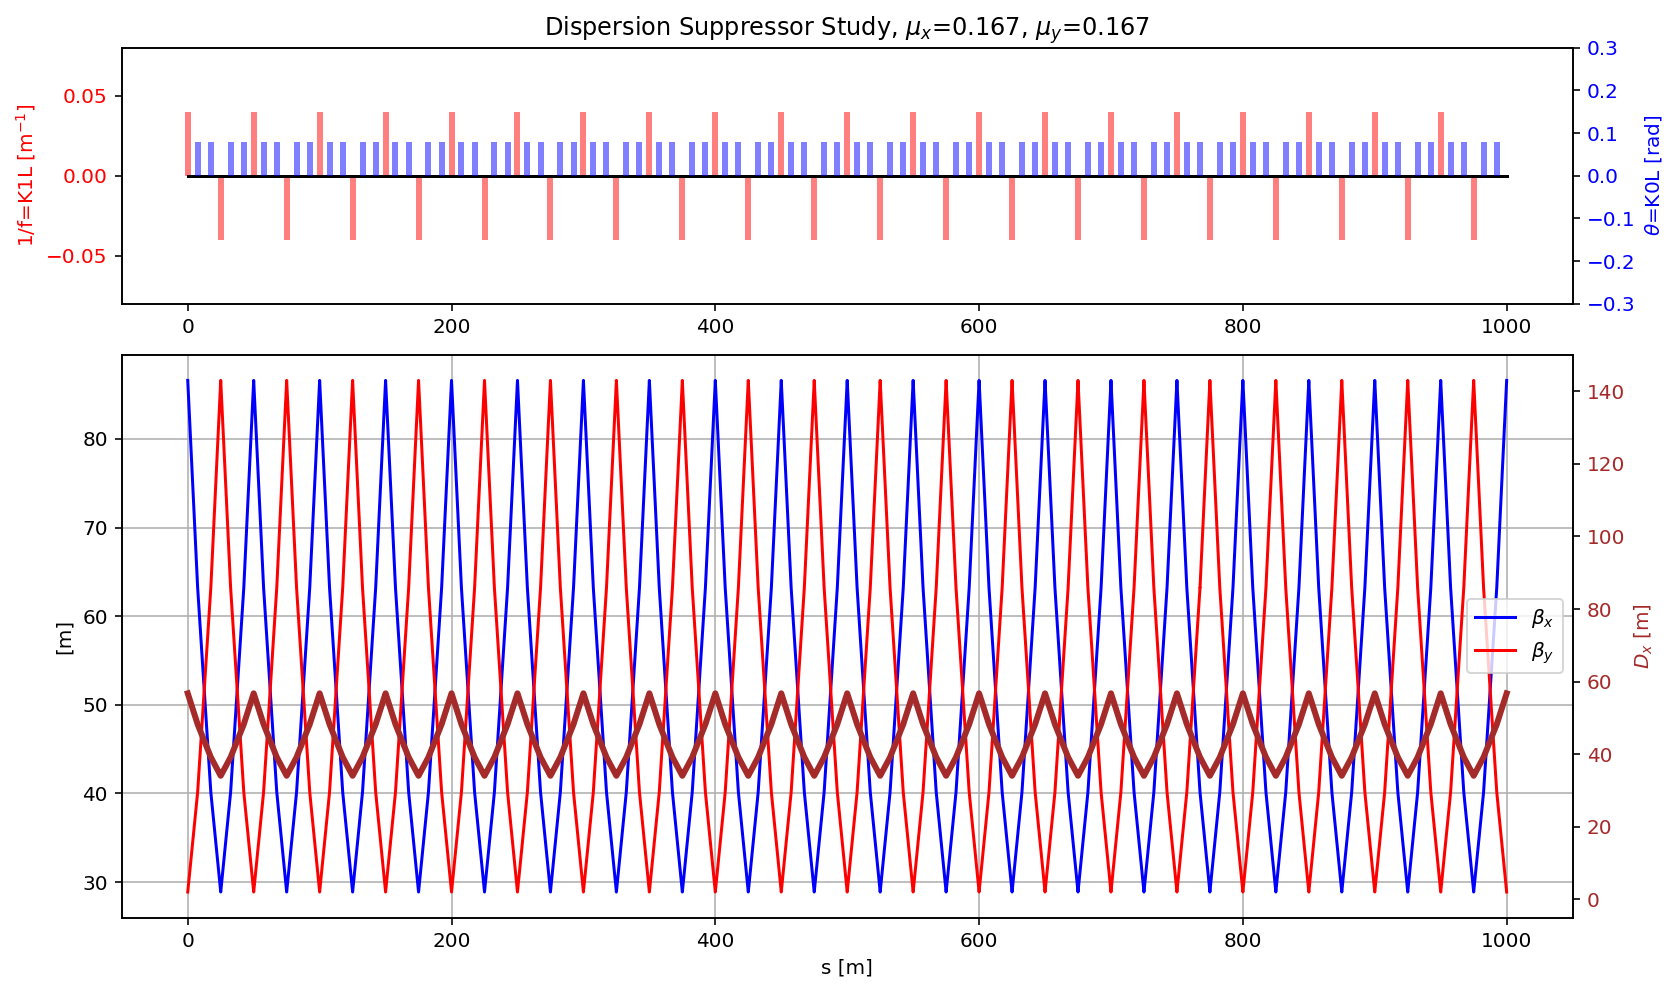

In [22]:
madx = Madx(stdout=False)
madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*1/6;
  global,sequence=mySequence,Q2=ncell*1/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
twiss;
/*
seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];

replace, element=mb[5], by=mb_half;
replace, element=mb[6], by=mb_half;
replace, element=mb[7], by=mb_half;
replace, element=mb[8], by=mb_half;
replace, element=mb[9], by=mb_half;
replace, element=mb[10], by=mb_half;
replace, element=mb[11], by=mb_half;
replace, element=mb[12], by=mb_half;

replace, element=mb[29], by=mb_half;
replace, element=mb[30], by=mb_half;
replace, element=mb[31], by=mb_half;
replace, element=mb[32], by=mb_half;
replace, element=mb[33], by=mb_half;
replace, element=mb[34], by=mb_half;
replace, element=mb[35], by=mb_half;
replace, element=mb[36], by=mb_half;

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];

replace, element=mb[45], by=mb_half;
replace, element=mb[46], by=mb_half;
replace, element=mb[47], by=mb_half;
replace, element=mb[48], by=mb_half;
replace, element=mb[49], by=mb_half;
replace, element=mb[50], by=mb_half;
replace, element=mb[51], by=mb_half;
replace, element=mb[52], by=mb_half;

replace, element=mb[69], by=mb_half;
replace, element=mb[70], by=mb_half;
replace, element=mb[71], by=mb_half;
replace, element=mb[72], by=mb_half;
replace, element=mb[73], by=mb_half;
replace, element=mb[74], by=mb_half;
replace, element=mb[75], by=mb_half;
replace, element=mb[76], by=mb_half;

remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;
*/
!use, sequence=mySequence;
!angleBending=2.0*pi/(4*ncell-32);
!twiss;
''')

myTwiss=madx.table.twiss.dframe()
myTwissRef=madx.table.twiss.dframe()
# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 150)


(-70.0, 150.0)

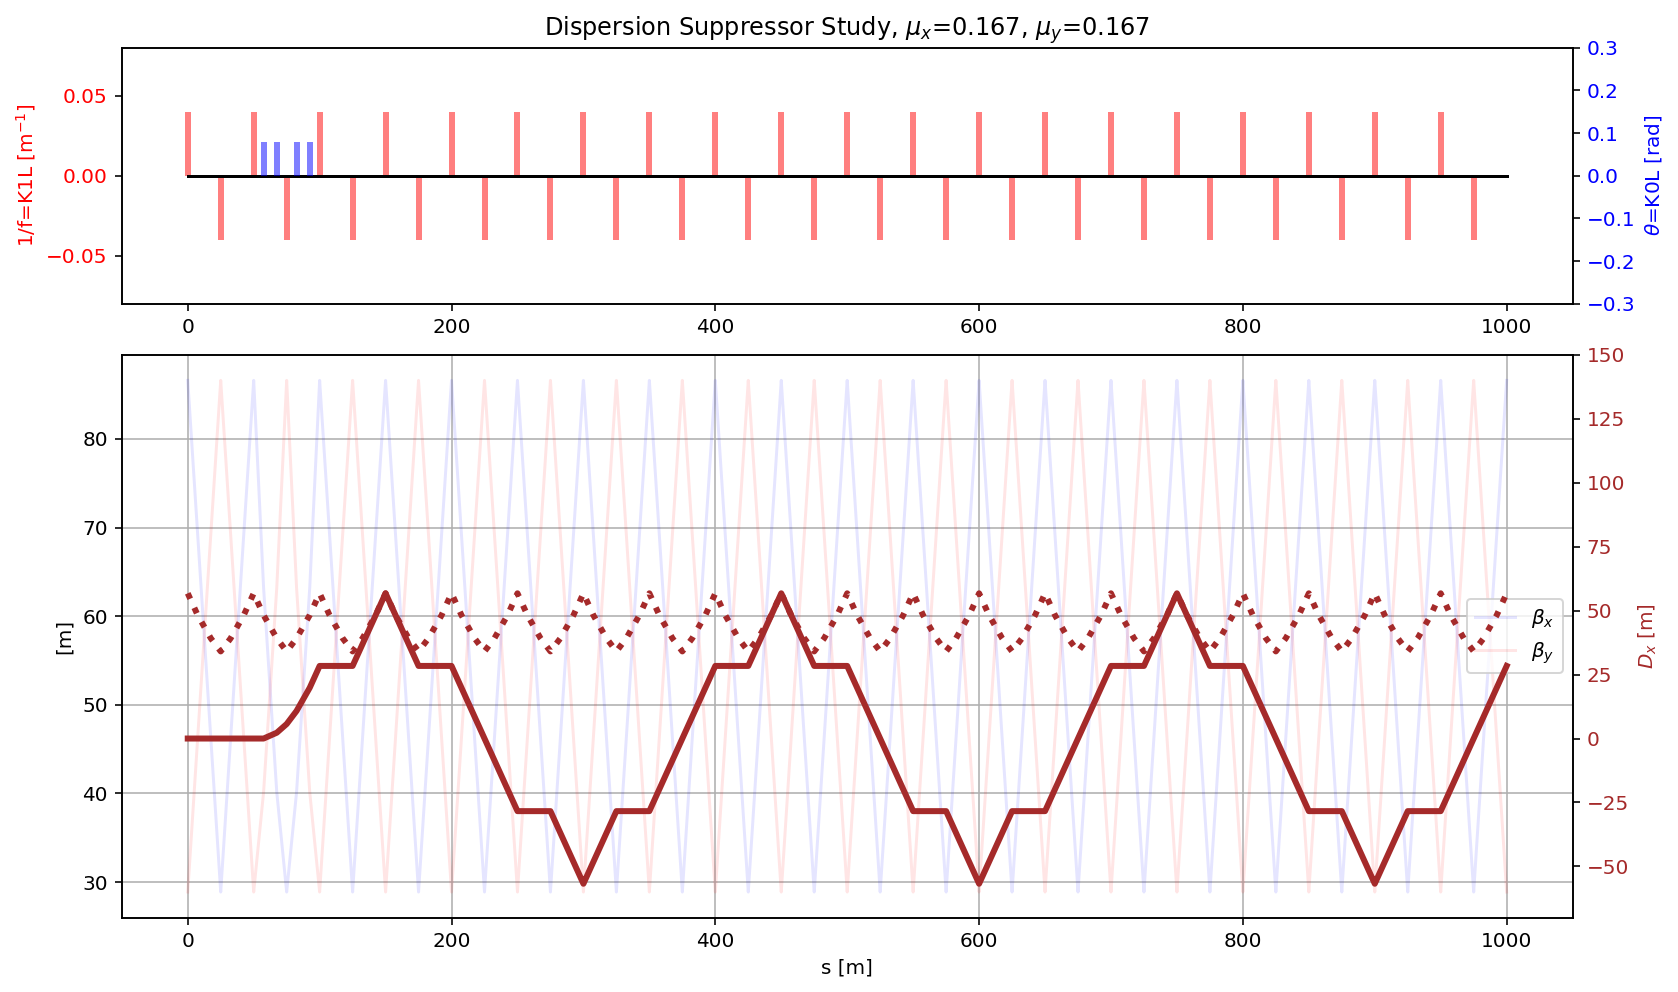

In [23]:
madx = Madx(stdout=False)
myRemoval=''
for i in range(9,81):
    myRemoval+='remove, element=mb['+str(i)+ '];'
madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*1/6;
  global,sequence=mySequence,Q2=ncell*1/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
savebeta, label=myStart, place=#s, sequence=mySequence;
twiss;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];
'''+myRemoval+'''
flatten;
endedit;

use, sequence=mySequence;
!angleBending=2.0*pi/(4*ncell-32);
twiss, betx=myStart->betx,bety=myStart->bety,alfx=myStart->alfx,alfy=myStart->alfy,dx=0, dpx=0;
''')

myTwiss=madx.table.twiss.dframe()
# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$', alpha=.1)
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$', alpha=.1)
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
plt.plot(myTwissRef['s'],myTwissRef['dx'],'brown', label='$D_x$', lw=3, ls=':')

ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-70, 150)

By traslating the FODO cell with the dipoles along the machine, as one expects, the dispersive wave move accordingly.

(-70.0, 150.0)

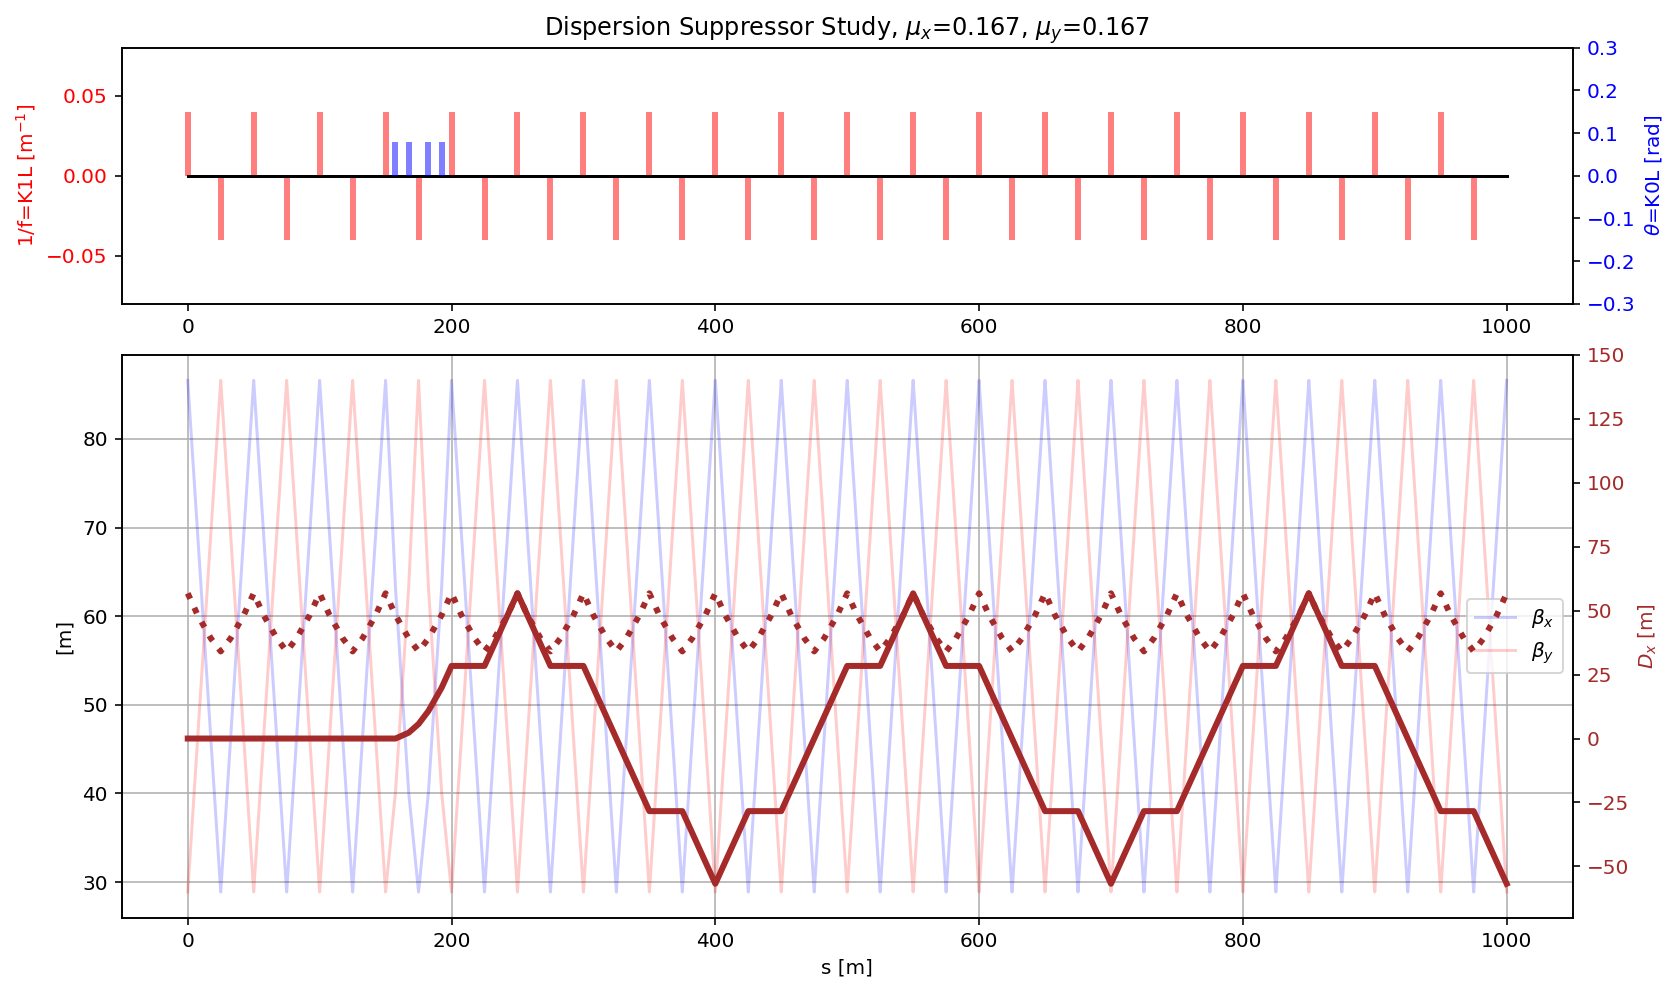

In [10]:
madx = Madx(stdout=False)
myRemoval=''
for i in range(17,81):
    myRemoval+='remove, element=mb['+str(i)+ '];'
madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*1/6;
  global,sequence=mySequence,Q2=ncell*1/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
savebeta, label=myStart, place=#s, sequence=mySequence;
twiss;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];
remove, element=mb[5];
remove, element=mb[6];
remove, element=mb[7];
remove, element=mb[8];
remove, element=mb[9];
remove, element=mb[10];
remove, element=mb[11];
remove, element=mb[12];
'''+myRemoval+'''
flatten;
endedit;
use, sequence=mySequence;
!angleBending=2.0*pi/(4*ncell-32);
twiss, betx=myStart->betx,bety=myStart->bety,alfx=myStart->alfx,alfy=myStart->alfy,dx=0, dpx=0;
''')

myTwiss=madx.table.twiss.dframe()
# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$', alpha=.2)
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$', alpha=.2)
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
plt.plot(myTwissRef['s'],myTwissRef['dx'],'brown', label='$D_x$', lw=3, ls=':')

ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-70, 150)

Due to the linearity we can **sum-up the dispersive waves** and try to match it to the periodic dispersive functions.

(-70.0, 150.0)

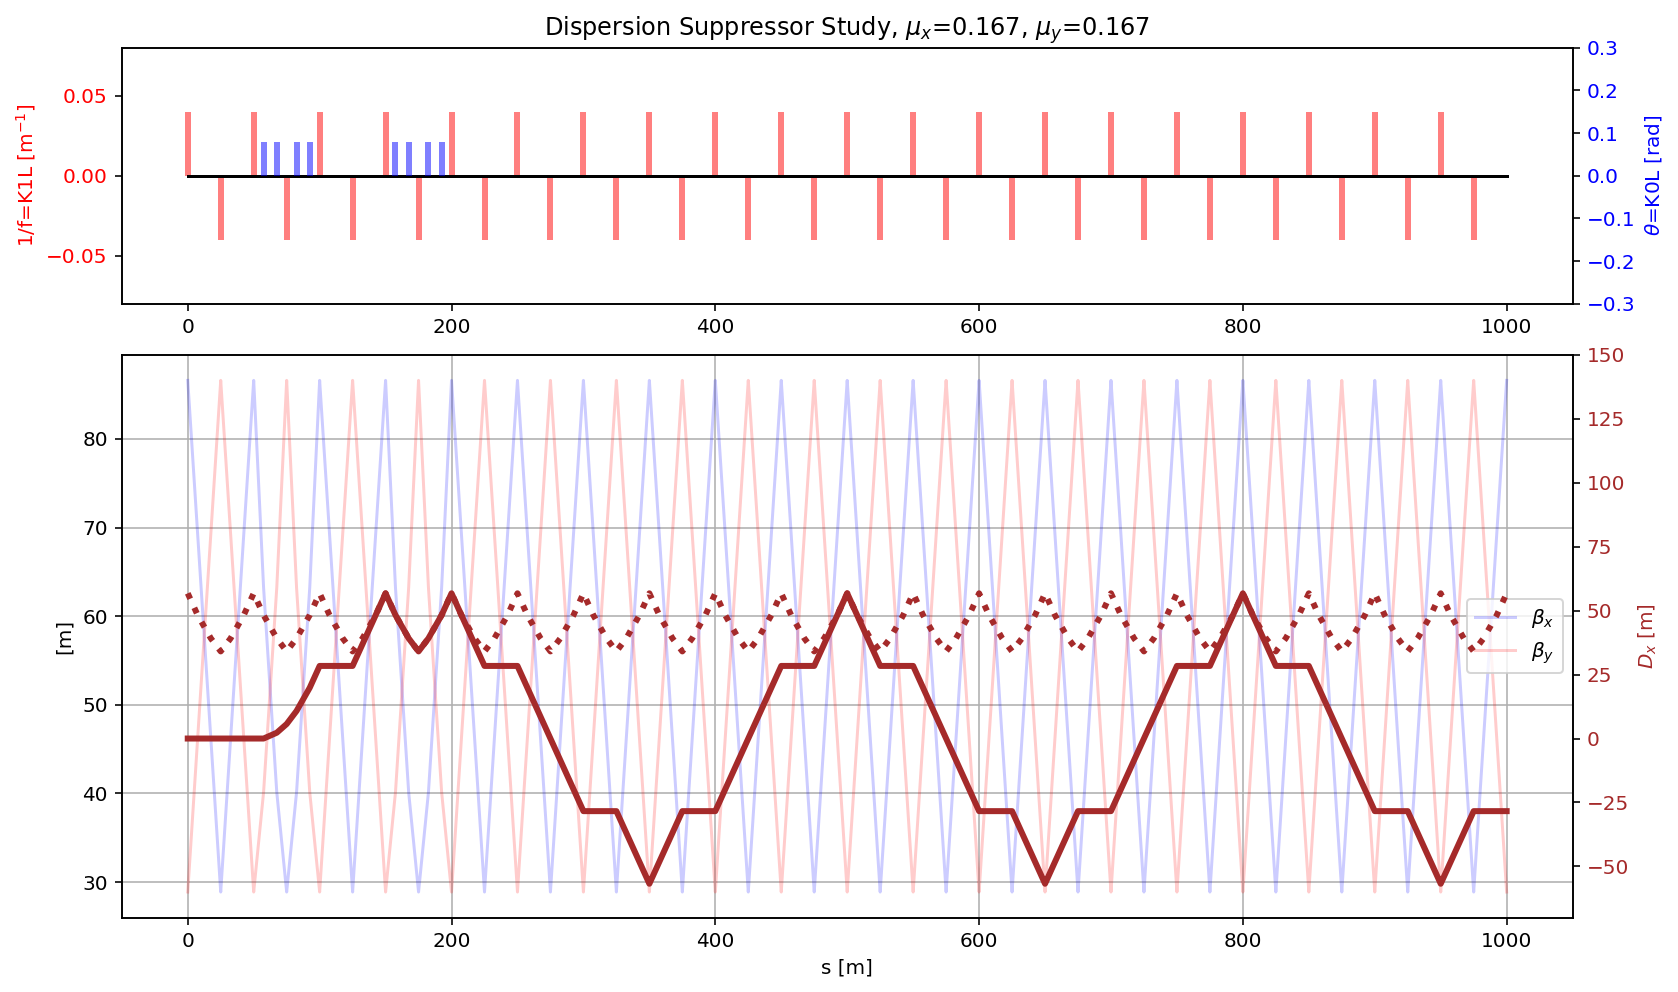

In [11]:
madx = Madx(stdout=False)
myRemoval=''
for i in range(17,81):
    myRemoval+='remove, element=mb['+str(i)+ '];'
madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*1/6;
  global,sequence=mySequence,Q2=ncell*1/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
savebeta, label=myStart, place=#s, sequence=mySequence;
twiss;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];
remove, element=mb[9];
remove, element=mb[10];
remove, element=mb[11];
remove, element=mb[12];
'''+myRemoval+'''
flatten;
endedit;
use, sequence=mySequence;
!angleBending=2.0*pi/(4*ncell-32);
twiss, betx=myStart->betx,bety=myStart->bety,alfx=myStart->alfx,alfy=myStart->alfy,dx=0, dpx=0;
''')

myTwiss=madx.table.twiss.dframe()
# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$', alpha=.2)
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$', alpha=.2)
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
plt.plot(myTwissRef['s'],myTwissRef['dx'],'brown', label='$D_x$', lw=3, ls=':')

ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-70, 150)

And now we can add others "FODO with dipoles" to sustain the dispersive wave.

(-70.0, 150.0)

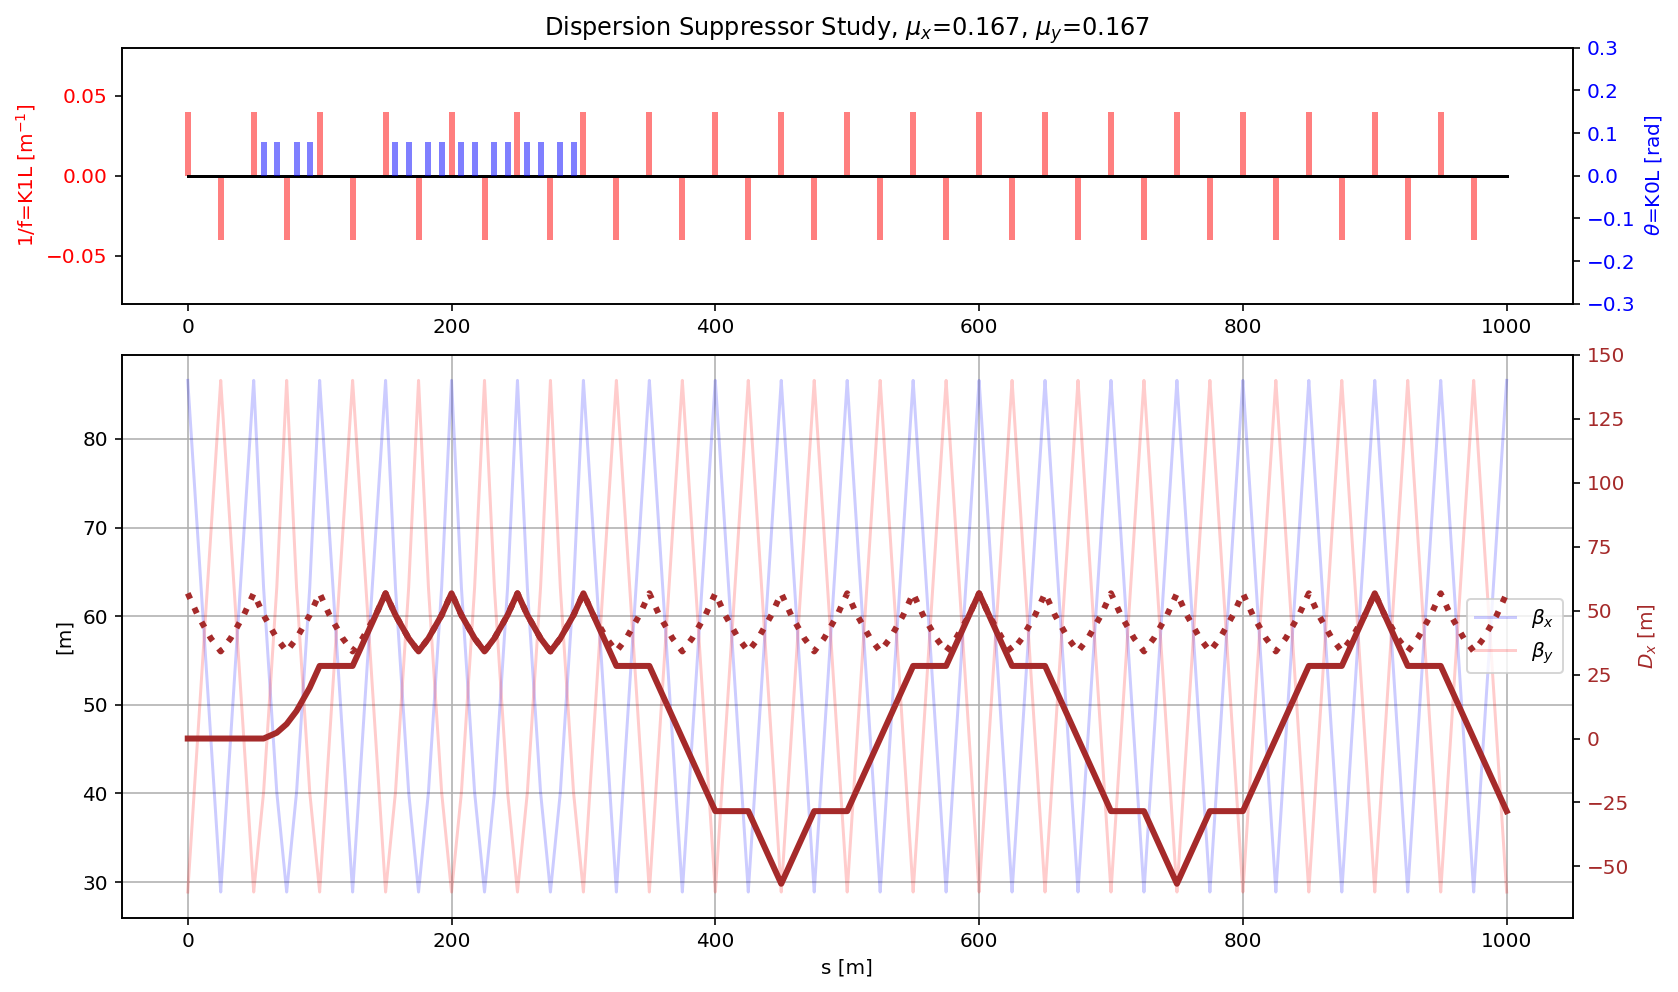

In [13]:
madx = Madx(stdout=False)
myRemoval=''
for i in range(25,81):
    myRemoval+='remove, element=mb['+str(i)+ '];'
madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*1/6;
  global,sequence=mySequence,Q2=ncell*1/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
savebeta, label=myStart, place=#s, sequence=mySequence;
twiss;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];
remove, element=mb[9];
remove, element=mb[10];
remove, element=mb[11];
remove, element=mb[12];
'''+myRemoval+'''
flatten;
endedit;
use, sequence=mySequence;
!angleBending=2.0*pi/(4*ncell-32);
twiss, betx=myStart->betx,bety=myStart->bety,alfx=myStart->alfx,alfy=myStart->alfy,dx=0, dpx=0;
''')

myTwiss=madx.table.twiss.dframe()
# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$', alpha=.2)
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$', alpha=.2)
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
plt.plot(myTwissRef['s'],myTwissRef['dx'],'brown', label='$D_x$', lw=3, ls=':')

ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-70, 150)

This initial consideration give rise to a series of topologies that we can consider for the dispersion suppressor. We need to pay attention that supressing the main bends **changes the reference orbit** so we need to verify the closure of the circular machine.

In addition it is quite "expensive" to remove dipoles in a high energy collider and it is not very convenient to impose a stringent phase advance of the arc of the machine. This schema has to be consider a starting point and in reality work (also) together with the quadrupole of the matching sections.

One can show that the following equation holds
\begin{equation}
\mu_{cell}=\frac{2 k+1}{2 m+n} \pi
\end{equation}
where $k\in\{0,1,\dots\}$, $m$ is the number of regular cells between the Interaction Point and the arc and $n$ is the number of missing-dipole cells. After having defined $m$ and $n$ we chose $\mu_{cell}$ accordingly.
We will do few examples.

# Missing bending with m=1 and n=1

In [15]:
madx = Madx(stdout=False)
madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*1/6;
  global,sequence=mySequence,Q2=ncell*1/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
twiss;
/*
seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];

replace, element=mb[5], by=mb_half;
replace, element=mb[6], by=mb_half;
replace, element=mb[7], by=mb_half;
replace, element=mb[8], by=mb_half;
replace, element=mb[9], by=mb_half;
replace, element=mb[10], by=mb_half;
replace, element=mb[11], by=mb_half;
replace, element=mb[12], by=mb_half;

replace, element=mb[29], by=mb_half;
replace, element=mb[30], by=mb_half;
replace, element=mb[31], by=mb_half;
replace, element=mb[32], by=mb_half;
replace, element=mb[33], by=mb_half;
replace, element=mb[34], by=mb_half;
replace, element=mb[35], by=mb_half;
replace, element=mb[36], by=mb_half;

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];

replace, element=mb[45], by=mb_half;
replace, element=mb[46], by=mb_half;
replace, element=mb[47], by=mb_half;
replace, element=mb[48], by=mb_half;
replace, element=mb[49], by=mb_half;
replace, element=mb[50], by=mb_half;
replace, element=mb[51], by=mb_half;
replace, element=mb[52], by=mb_half;

replace, element=mb[69], by=mb_half;
replace, element=mb[70], by=mb_half;
replace, element=mb[71], by=mb_half;
replace, element=mb[72], by=mb_half;
replace, element=mb[73], by=mb_half;
replace, element=mb[74], by=mb_half;
replace, element=mb[75], by=mb_half;
replace, element=mb[76], by=mb_half;

remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;
*/
!use, sequence=mySequence;
!angleBending=2.0*pi/(4*ncell-32);
!twiss;
''')
madx.input('''
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell/6;
  global,sequence=mySequence,Q2=ncell/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
''')
if 0:
    myTwiss=madx.table.twiss.dframe()

    # plotting the results
    fig = plt.figure(figsize=(13,8))
    # set up subplot grid
    #gridspec.GridSpec(3,3)

    ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
    plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


    DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    DF=myTwiss[(myTwiss['keyword']=='multipole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')


    color = 'red'
    ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ylim(-.08,.08)
    plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'blue'
    ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=color)


    #DF=myTwiss[(myTwiss['keyword']=='sbend')]
    #for i in range(len(DF)):
    #    aux=DF.iloc[i]
    #    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

    DF=myTwiss[(myTwiss['keyword']=='multipole')]
    for i in range(len(DF)):
        aux=DF.iloc[i]
        plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

    plt.ylim(-.2,.2)

    # large subplot
    plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

    plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
    plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
    plt.legend(loc='best')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()

    ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
    plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
    ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
    ax3.tick_params(axis='y', labelcolor='brown')
    plt.ylim(-5, 150)

    madx.input('survey;')
    mySurvey=madx.table.survey.dframe()
    plt.scatter(mySurvey['z'],mySurvey['x'],c=mySurvey['s'])
    plt.axis('equal')
    plt.xlabel('z [m]')
    plt.ylabel('x [m]')
    plt.grid()
    cbar = plt.colorbar()
    cbar.set_label('s [m]')
    plt.title('My simple synchrotron');

(-5.0, 150.0)

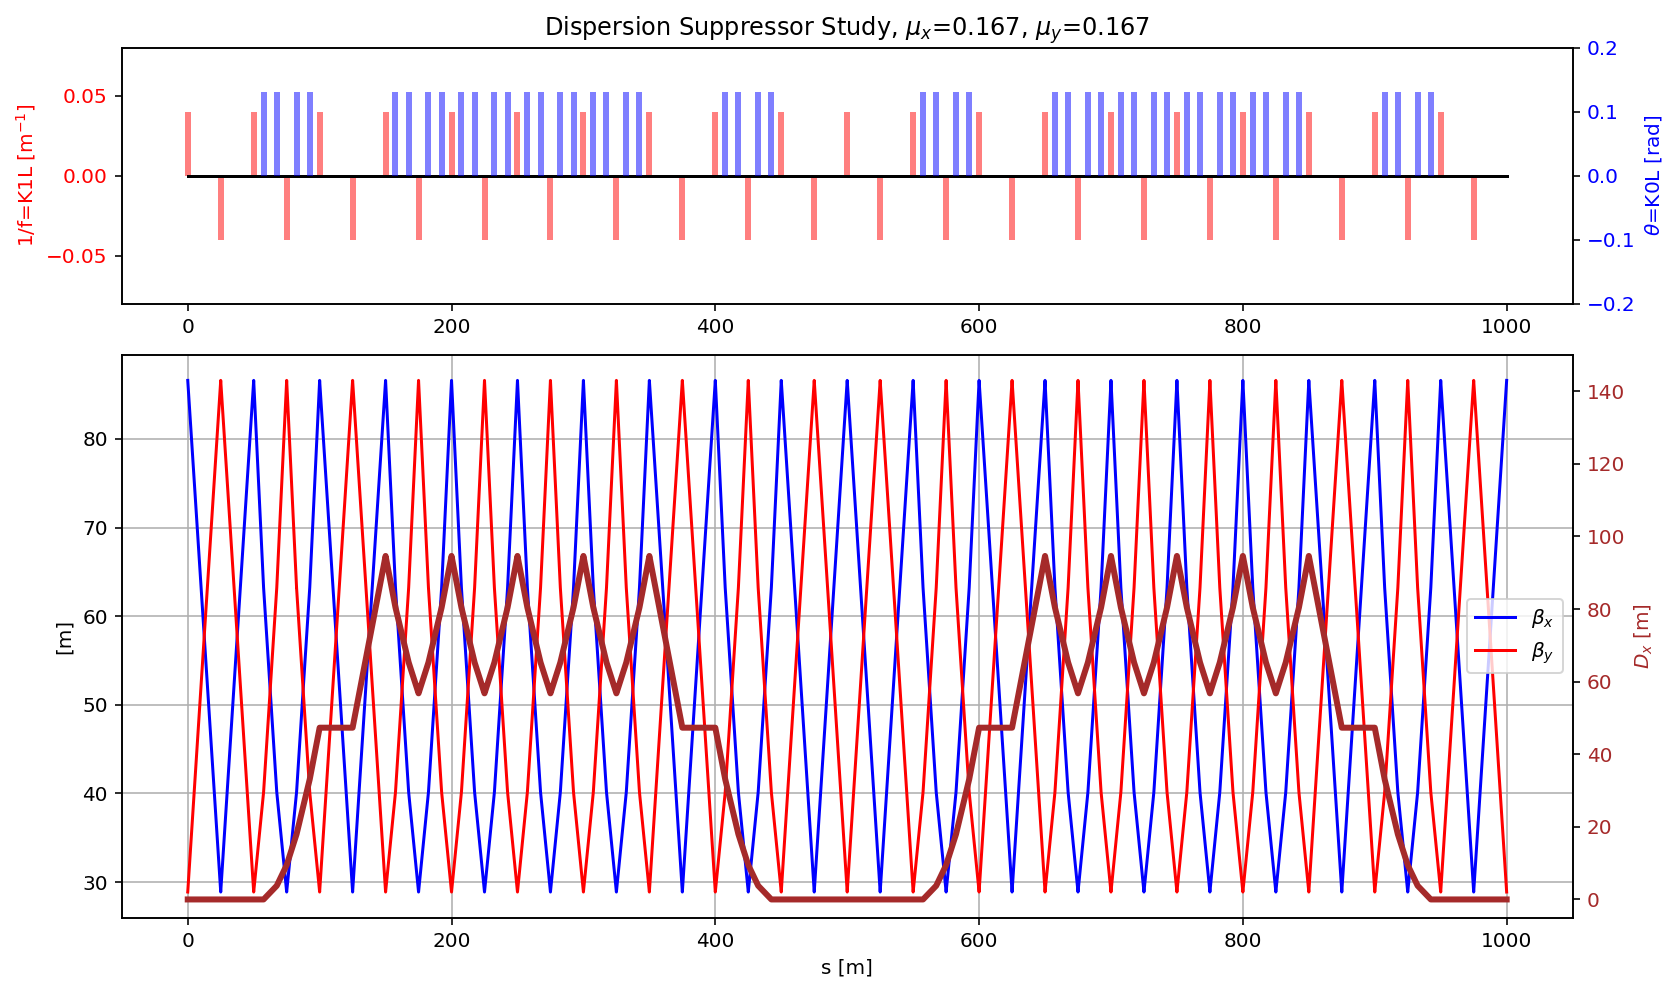

In [16]:
madx.input('''
seqedit, sequence=mySequence;
flatten;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];
remove, element=mb[9];
remove, element=mb[10];
remove, element=mb[11];
remove, element=mb[12];


remove, element=mb[29];
remove, element=mb[30];
remove, element=mb[31];
remove, element=mb[32];

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];

remove, element=mb[49];
remove, element=mb[50];
remove, element=mb[51];
remove, element=mb[52];


remove, element=mb[69];
remove, element=mb[70];
remove, element=mb[71];
remove, element=mb[72];
remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;
use, sequence=mySequence;
angleBending=2.0*pi/(4*ncell-32);
twiss;
''')

myTwiss=madx.table.twiss.dframe()

# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.2,.2)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 150)

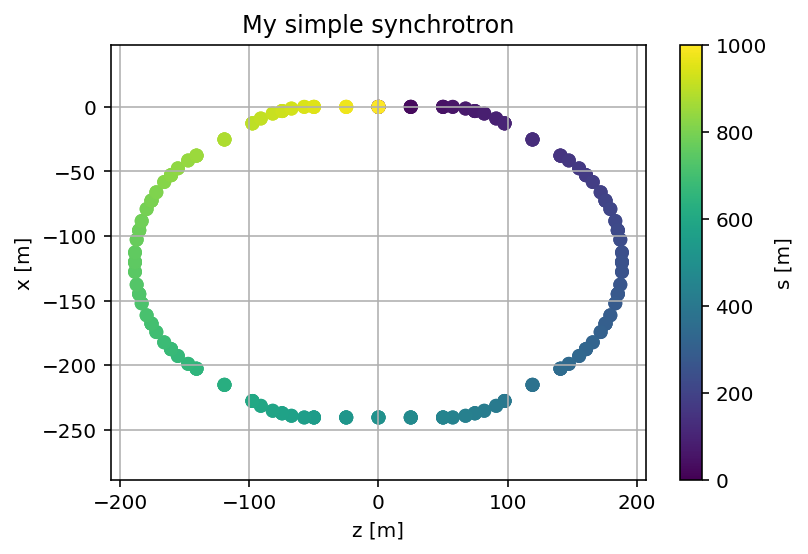

In [17]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()
plt.scatter(mySurvey['z'],mySurvey['x'],c=mySurvey['s'])
plt.axis('equal')
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('s [m]')
plt.title('My simple synchrotron');

# Missing bending with m=1 and n=0
This is the pure racetrack configuration.

(-5.0, 150.0)

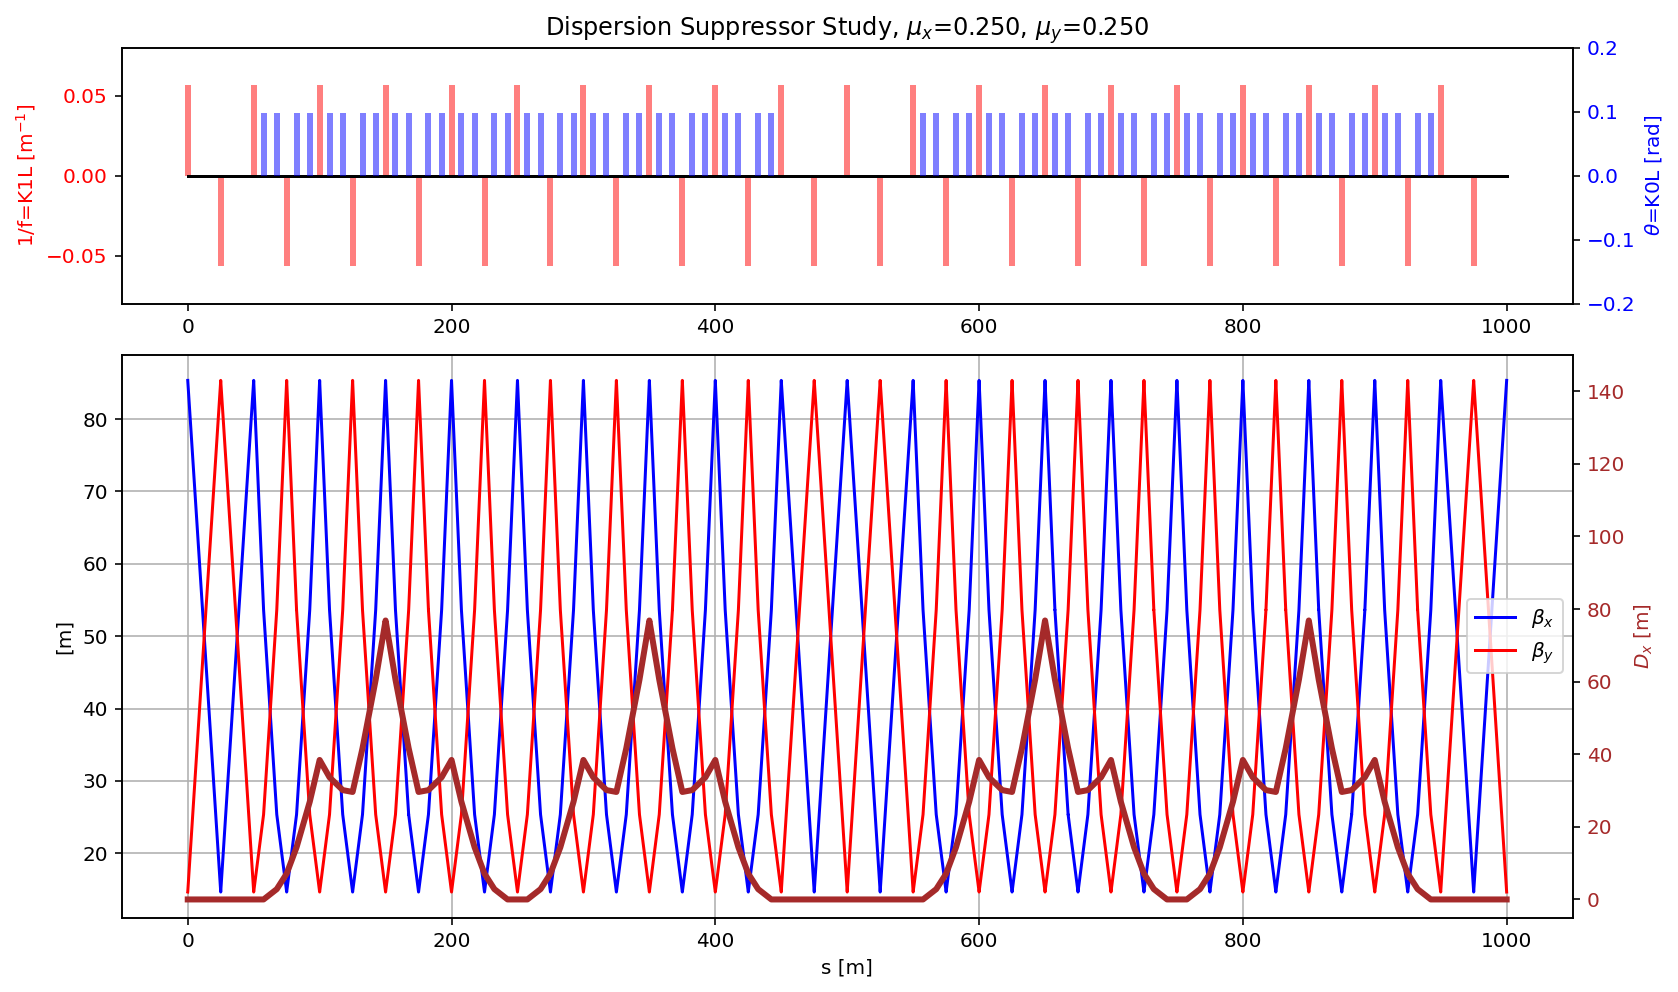

In [18]:
madx = Madx(stdout=False)

madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*.25;
  global,sequence=mySequence,Q2=ncell*.25;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
twiss;

seqedit, sequence=mySequence;
flatten;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];


remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;
use, sequence=mySequence;
angleBending=2.0*pi/(4*ncell-16);
twiss;
''')


myTwiss=madx.table.twiss.dframe()

# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.2,.2)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 150)

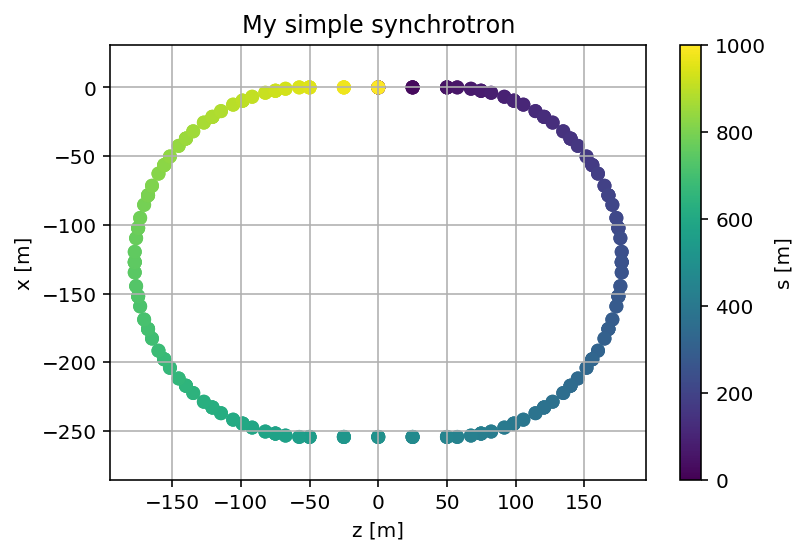

In [13]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()
plt.scatter(mySurvey['z'],mySurvey['x'],c=mySurvey['s'])
plt.axis('equal')
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('s [m]')
plt.title('My simple synchrotron');

# Missing bending with m=0 and n=1
This is not possible since would require a $\pi$ phase advance.

# Missing bending with m=1 and n=2
This has two reasonable solution ($\pi/4$ and $3\pi/4$)

(-5, 180)

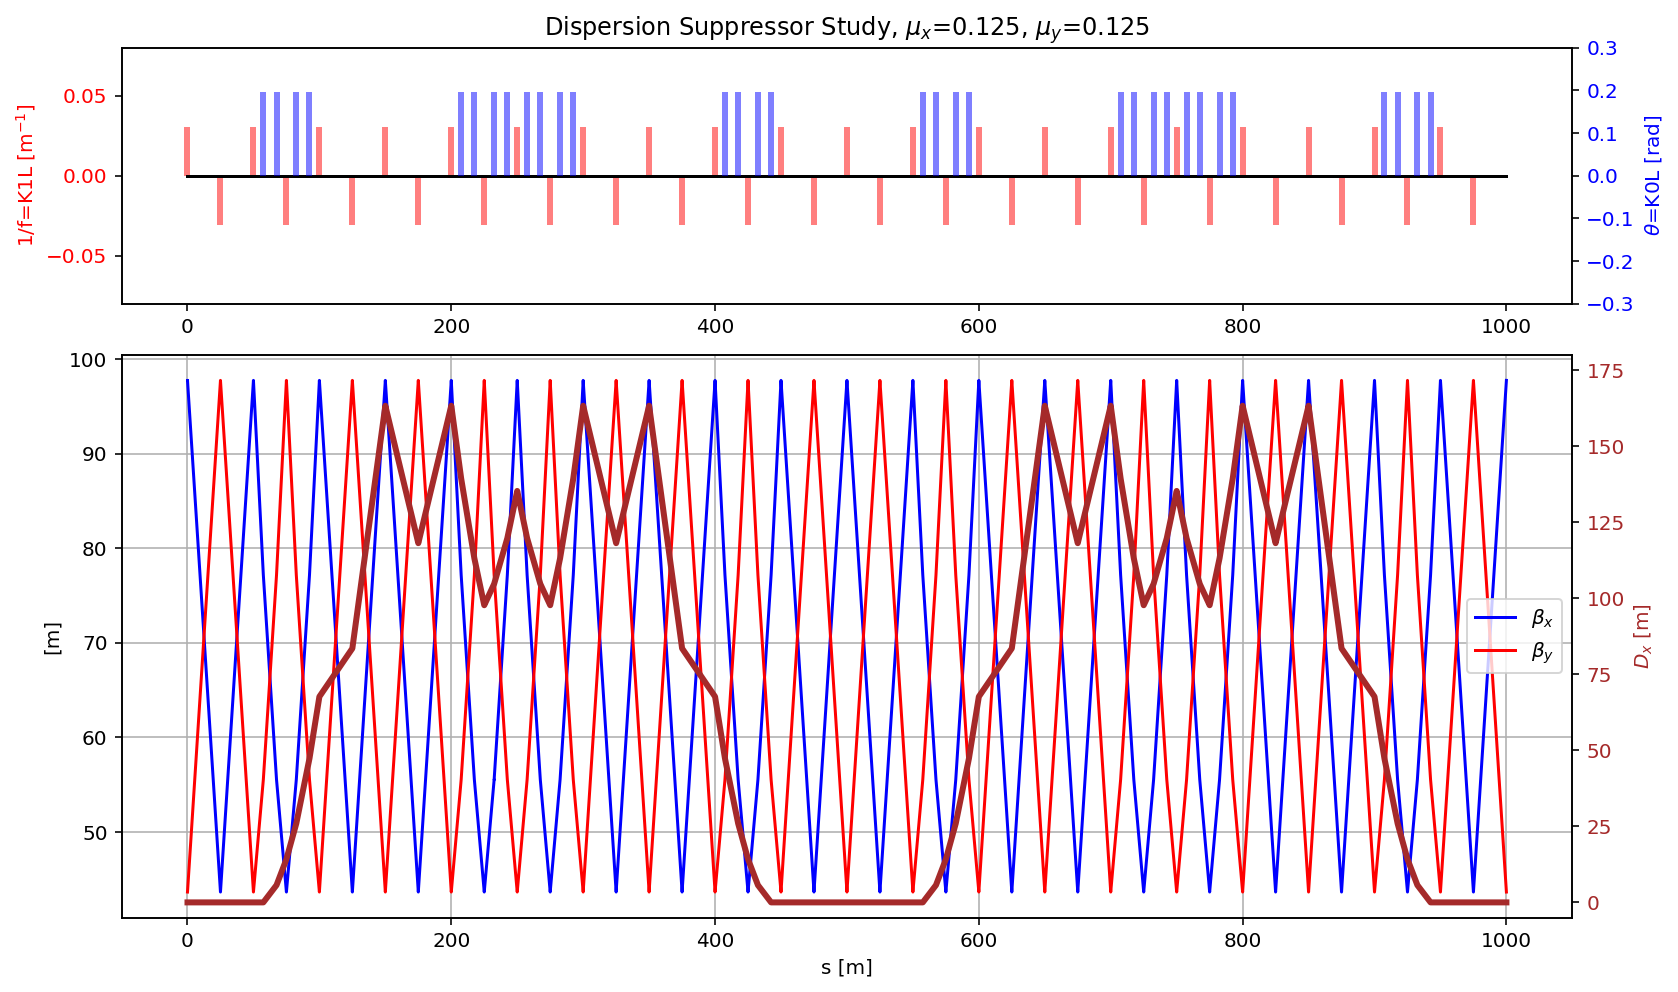

In [14]:
madx = Madx(stdout=False)

madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*.125;
  global,sequence=mySequence,Q2=ncell*.125;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
twiss;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];

remove, element=mb[9];
remove, element=mb[10];
remove, element=mb[11];
remove, element=mb[12];
remove, element=mb[13];
remove, element=mb[14];
remove, element=mb[15];
remove, element=mb[16];

remove, element=mb[25];
remove, element=mb[26];
remove, element=mb[27];
remove, element=mb[28];
remove, element=mb[29];
remove, element=mb[30];
remove, element=mb[31];
remove, element=mb[32];

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];

remove, element=mb[49];
remove, element=mb[50];
remove, element=mb[51];
remove, element=mb[52];
remove, element=mb[53];
remove, element=mb[54];
remove, element=mb[55];
remove, element=mb[56];

remove, element=mb[65];
remove, element=mb[66];
remove, element=mb[67];
remove, element=mb[68];
remove, element=mb[69];
remove, element=mb[70];
remove, element=mb[71];
remove, element=mb[72];

remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;

use, sequence=mySequence;
angleBending=2.0*pi/(4*ncell-48);
twiss;
''')

myTwiss=madx.table.twiss.dframe()

# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 180)

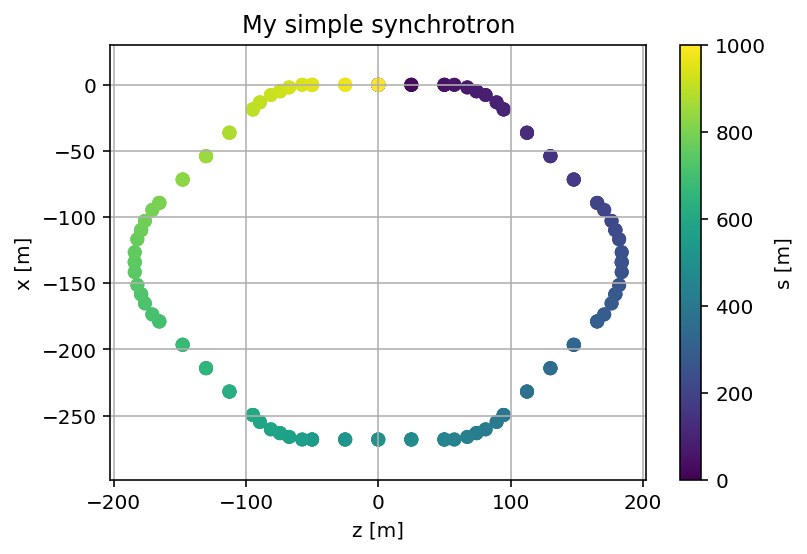

In [15]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()
plt.scatter(mySurvey['z'],mySurvey['x'],c=mySurvey['s'])
plt.axis('equal')
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('s [m]')
plt.title('My simple synchrotron');

(-50, 180)

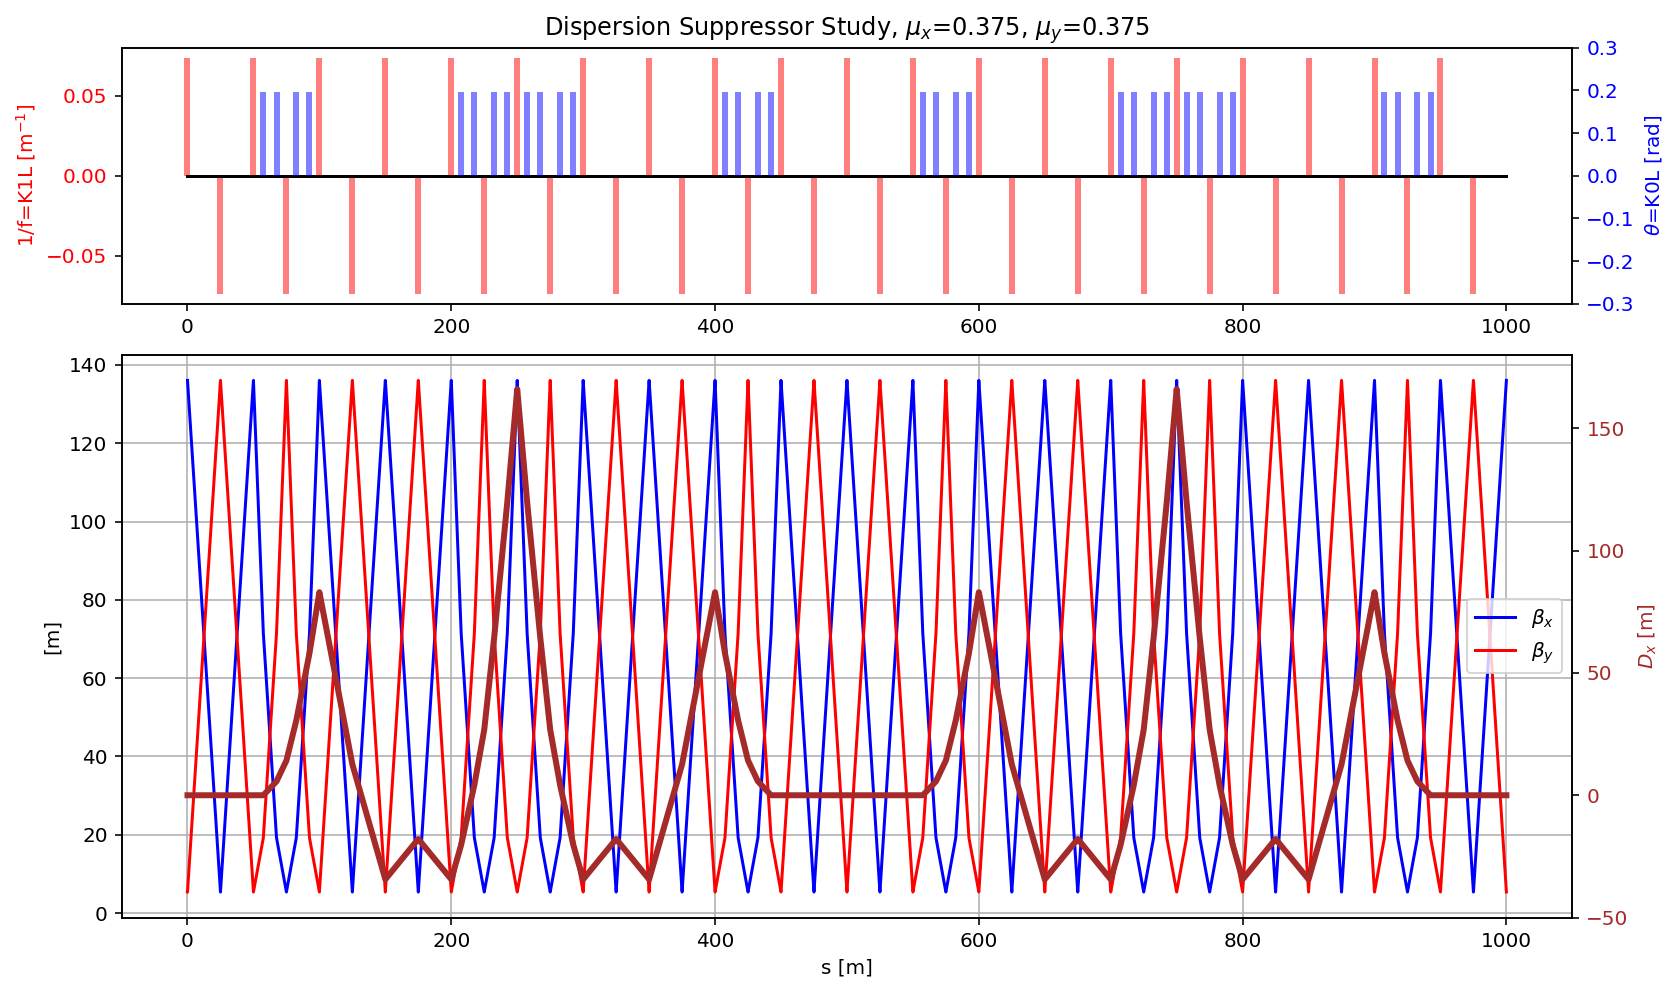

In [16]:
madx = Madx(stdout=False)

madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*.25;
  global,sequence=mySequence,Q2=ncell*.25;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*.125*3;
  global,sequence=mySequence,Q2=ncell*.125*3;
  Lmdif, calls=1000, tolerance=1.0e-21;
endmatch;
;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];

remove, element=mb[9];
remove, element=mb[10];
remove, element=mb[11];
remove, element=mb[12];
remove, element=mb[13];
remove, element=mb[14];
remove, element=mb[15];
remove, element=mb[16];

remove, element=mb[25];
remove, element=mb[26];
remove, element=mb[27];
remove, element=mb[28];
remove, element=mb[29];
remove, element=mb[30];
remove, element=mb[31];
remove, element=mb[32];

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];

remove, element=mb[49];
remove, element=mb[50];
remove, element=mb[51];
remove, element=mb[52];
remove, element=mb[53];
remove, element=mb[54];
remove, element=mb[55];
remove, element=mb[56];

remove, element=mb[65];
remove, element=mb[66];
remove, element=mb[67];
remove, element=mb[68];
remove, element=mb[69];
remove, element=mb[70];
remove, element=mb[71];
remove, element=mb[72];

remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;

use, sequence=mySequence;
angleBending=2.0*pi/(4*ncell-48);
twiss;
''')

myTwiss=madx.table.twiss.dframe()

# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$',lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-50, 180)

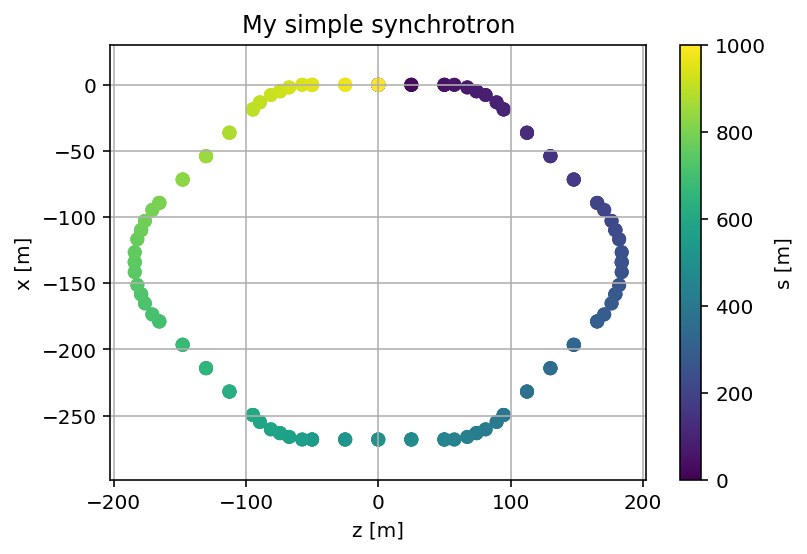

In [17]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()
plt.scatter(mySurvey['z'],mySurvey['x'],c=mySurvey['s'])
plt.axis('equal')
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('s [m]')
plt.title('My simple synchrotron');

# An alternative approach: using the half-bending topology.
Using a similar approach, we can reduce the bending strength of the dipoles in some specific FODO cells to suppress dispersion.

\begin{equation}
\sin^2 \left(\frac{n \mu_{cell}}{2}\right)=\frac{r}{2}
\end{equation}
where $n$ is the number of cells where the dipole strenght is $r$-times weaker than the one in the regular arc cells ($r>1$) and, as usual, $\mu_{cell}$ is the cell phase advance.

## With n=2 and r=2
This implies $\mu=\pi/2$.

(-5, 180)

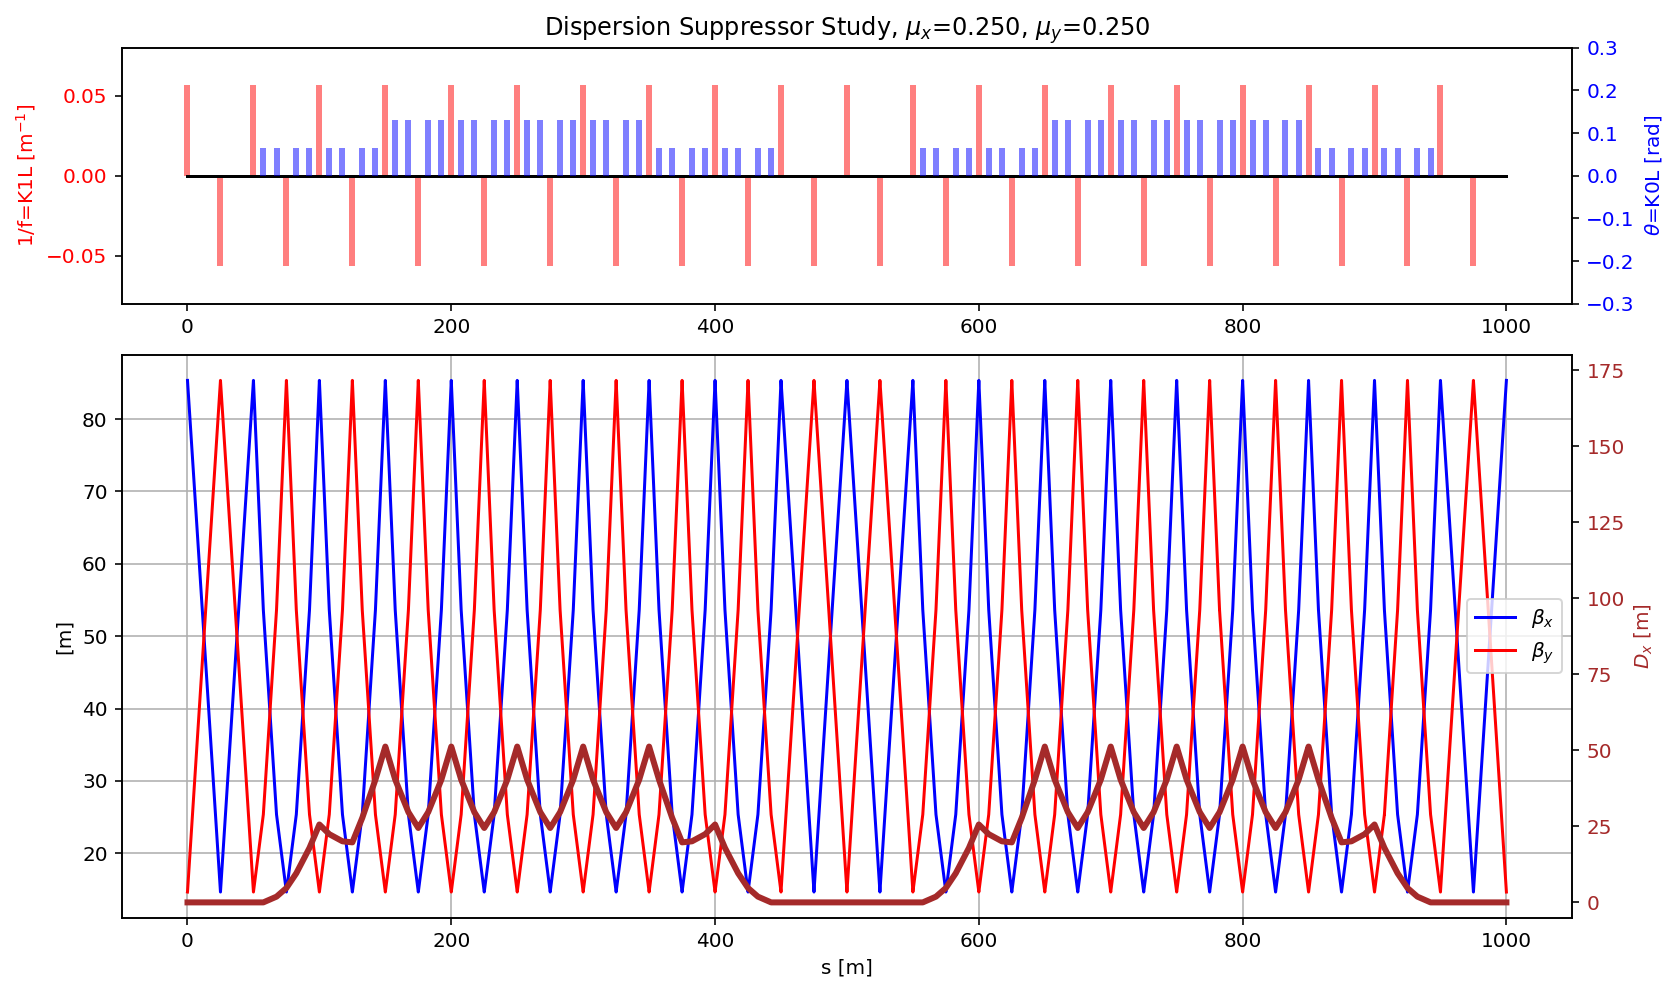

In [18]:
madx = Madx(stdout=False)

madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*.25;
  global,sequence=mySequence,Q2=ncell*.25;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
twiss;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];

replace, element=mb[5], by=mb_half;
replace, element=mb[6], by=mb_half;
replace, element=mb[7], by=mb_half;
replace, element=mb[8], by=mb_half;
replace, element=mb[9], by=mb_half;
replace, element=mb[10], by=mb_half;
replace, element=mb[11], by=mb_half;
replace, element=mb[12], by=mb_half;

replace, element=mb[29], by=mb_half;
replace, element=mb[30], by=mb_half;
replace, element=mb[31], by=mb_half;
replace, element=mb[32], by=mb_half;
replace, element=mb[33], by=mb_half;
replace, element=mb[34], by=mb_half;
replace, element=mb[35], by=mb_half;
replace, element=mb[36], by=mb_half;

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];

replace, element=mb[45], by=mb_half;
replace, element=mb[46], by=mb_half;
replace, element=mb[47], by=mb_half;
replace, element=mb[48], by=mb_half;
replace, element=mb[49], by=mb_half;
replace, element=mb[50], by=mb_half;
replace, element=mb[51], by=mb_half;
replace, element=mb[52], by=mb_half;

replace, element=mb[69], by=mb_half;
replace, element=mb[70], by=mb_half;
replace, element=mb[71], by=mb_half;
replace, element=mb[72], by=mb_half;
replace, element=mb[73], by=mb_half;
replace, element=mb[74], by=mb_half;
replace, element=mb[75], by=mb_half;
replace, element=mb[76], by=mb_half;

remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;

use, sequence=mySequence;
angleBending=2.0*pi/(4*ncell-32);
twiss;
''')

myTwiss=madx.table.twiss.dframe()

# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 180)

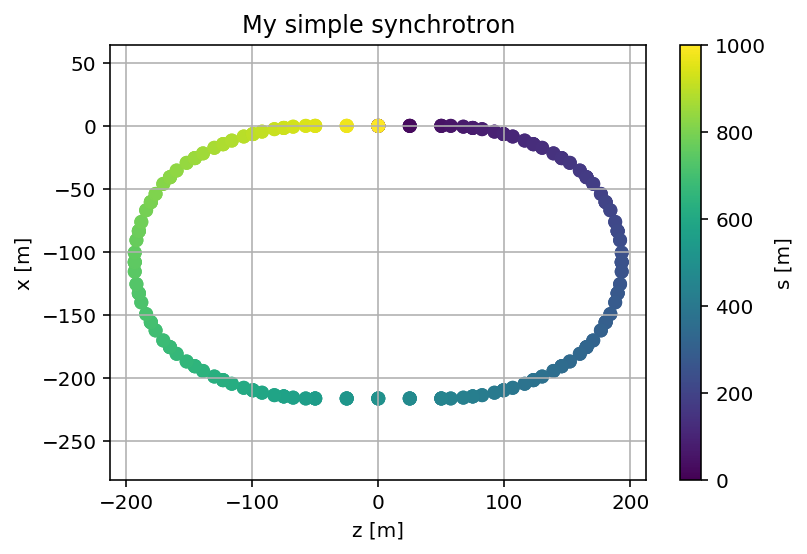

In [19]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()
plt.scatter(mySurvey['z'],mySurvey['x'],c=mySurvey['s'])
plt.axis('equal')
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('s [m]')
plt.title('My simple synchrotron');

### 3 half-bend cells and 60 deg phase advance.

(-5, 180)

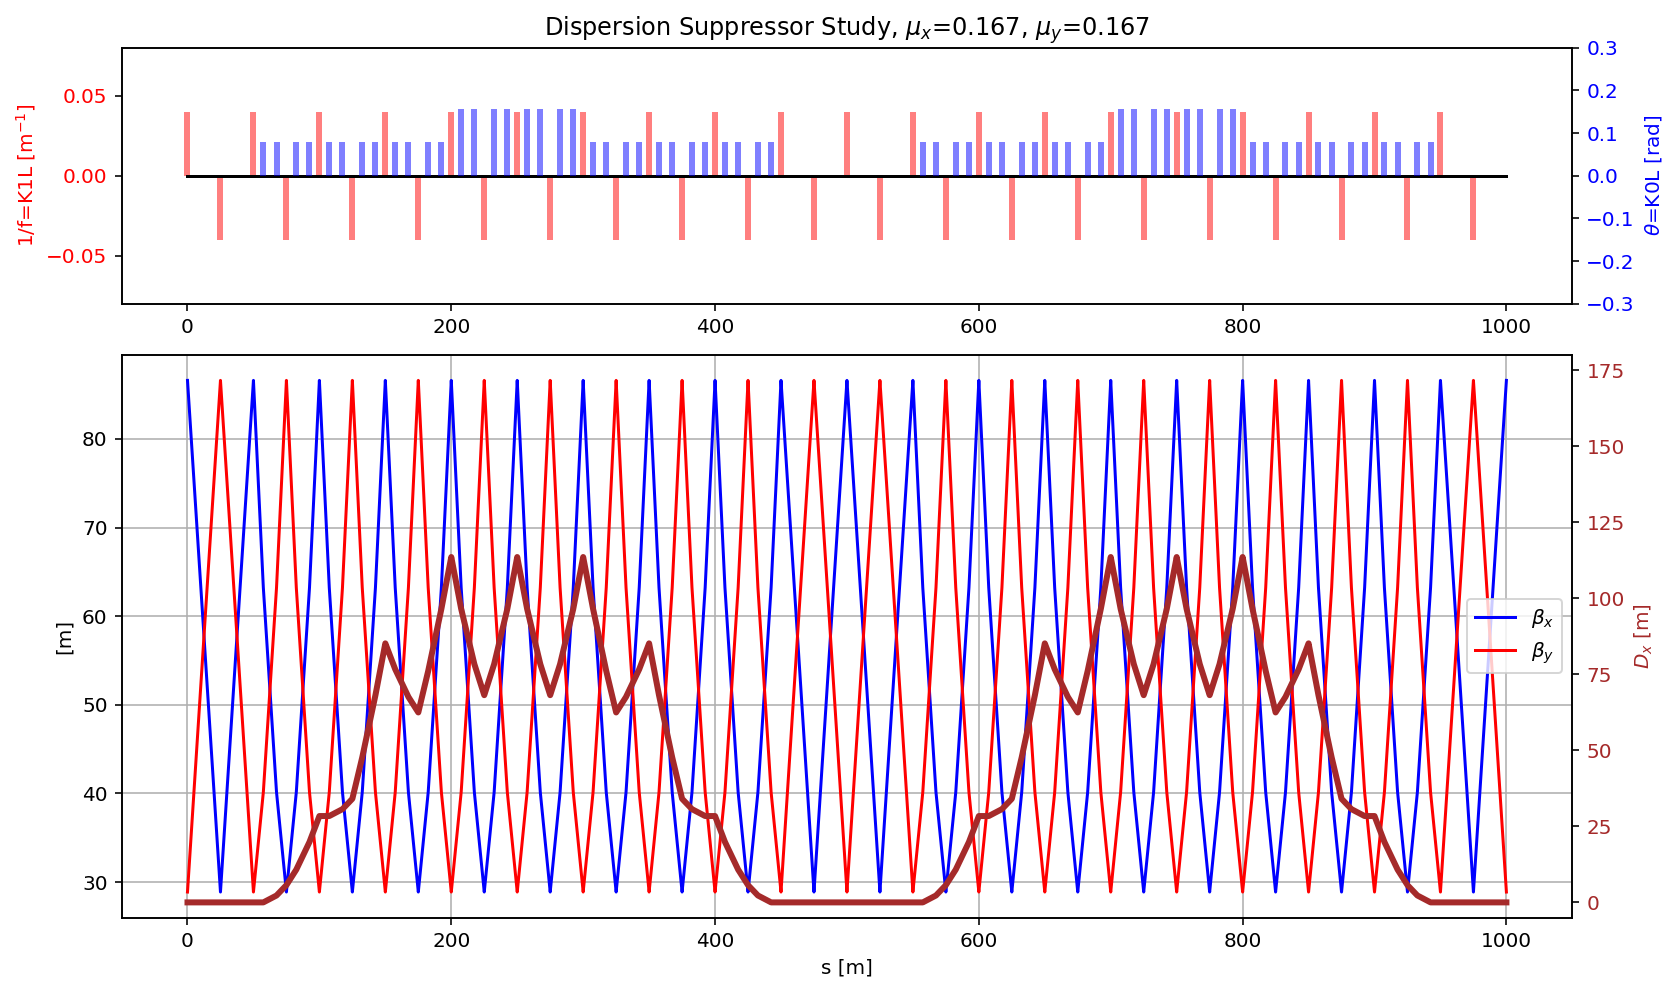

In [20]:
madx = Madx(stdout=False)

madx.input('''
circum=1000.0;
ncell = 20; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole
angleBending=2.0*pi/(4*ncell);

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl:={angleBending};
mb_half:multipole,knl:={angleBending/2};

kqf=0.0098;
kqd=-0.0098;
!define quadrupoles as multipoles 
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
mySequence: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
beam, particle = proton, sequence=mySequence;

use, sequence=mySequence;

select,flag=twiss, clear;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
match, sequence=mySequence;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=mySequence,Q1=ncell*1/6;
  global,sequence=mySequence,Q2=ncell*1/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;
twiss;

seqedit, sequence=mySequence;
remove, element=mb;
remove, element=mb[2];
remove, element=mb[3];
remove, element=mb[4];

replace, element=mb[5], by=mb_half;
replace, element=mb[6], by=mb_half;
replace, element=mb[7], by=mb_half;
replace, element=mb[8], by=mb_half;
replace, element=mb[9], by=mb_half;
replace, element=mb[10], by=mb_half;
replace, element=mb[11], by=mb_half;
replace, element=mb[12], by=mb_half;
replace, element=mb[13], by=mb_half;
replace, element=mb[14], by=mb_half;
replace, element=mb[15], by=mb_half;
replace, element=mb[16], by=mb_half;


replace, element=mb[25], by=mb_half;
replace, element=mb[26], by=mb_half;
replace, element=mb[27], by=mb_half;
replace, element=mb[28], by=mb_half;
replace, element=mb[29], by=mb_half;
replace, element=mb[30], by=mb_half;
replace, element=mb[31], by=mb_half;
replace, element=mb[32], by=mb_half;
replace, element=mb[33], by=mb_half;
replace, element=mb[34], by=mb_half;
replace, element=mb[35], by=mb_half;
replace, element=mb[36], by=mb_half;

remove, element=mb[37];
remove, element=mb[38];
remove, element=mb[39];
remove, element=mb[40];
remove, element=mb[41];
remove, element=mb[42];
remove, element=mb[43];
remove, element=mb[44];

replace, element=mb[45], by=mb_half;
replace, element=mb[46], by=mb_half;
replace, element=mb[47], by=mb_half;
replace, element=mb[48], by=mb_half;
replace, element=mb[49], by=mb_half;
replace, element=mb[50], by=mb_half;
replace, element=mb[51], by=mb_half;
replace, element=mb[52], by=mb_half;
replace, element=mb[53], by=mb_half;
replace, element=mb[54], by=mb_half;
replace, element=mb[55], by=mb_half;
replace, element=mb[56], by=mb_half;

replace, element=mb[65], by=mb_half;
replace, element=mb[66], by=mb_half;
replace, element=mb[67], by=mb_half;
replace, element=mb[68], by=mb_half;
replace, element=mb[69], by=mb_half;
replace, element=mb[70], by=mb_half;
replace, element=mb[71], by=mb_half;
replace, element=mb[72], by=mb_half;
replace, element=mb[73], by=mb_half;
replace, element=mb[74], by=mb_half;
replace, element=mb[75], by=mb_half;
replace, element=mb[76], by=mb_half;

remove, element=mb[77];
remove, element=mb[78];
remove, element=mb[79];
remove, element=mb[80];
flatten;
endedit;

use, sequence=mySequence;
angleBending=2.0*pi/(4*ncell-40);
twiss;
''')

myTwiss=madx.table.twiss.dframe()

# plotting the results
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Dispersion Suppressor Study, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 180)

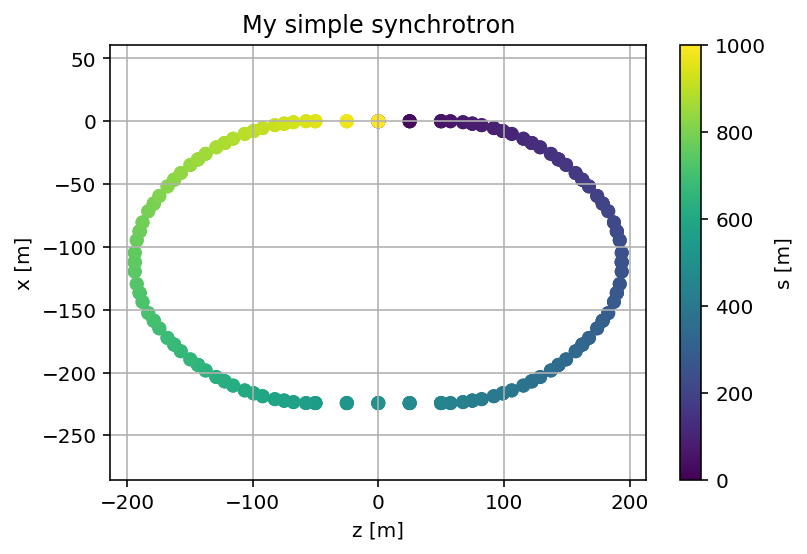

In [19]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()
plt.scatter(mySurvey['z'],mySurvey['x'],c=mySurvey['s'])
plt.axis('equal')
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.grid()
cbar = plt.colorbar()
cbar.set_label('s [m]')
plt.title('My simple synchrotron');